<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%205/Case_Study_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from numpy import arange
from sklearn.model_selection import GridSearchCV

#from example SVM notebook
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

Prediction on the Action column, for use with a firewall.

Port is like an address that allows connection like a tv channel.


In [87]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%205/log2.csv")
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [89]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [90]:
df['Source Port'] = df['Source Port'].astype(str)
df['Destination Port'] = df['Destination Port'].astype(str)
df['NAT Source Port'] = df['NAT Source Port'].astype(str)
df['NAT Destination Port'] = df['NAT Destination Port'].astype(str)

In [91]:
df.describe()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [92]:
value_counts = df['Source Port'].value_counts()
value_counts

58638    840
27005    513
443      273
57470    222
49418    210
        ... 
32996      1
60574      1
60570      1
65368      1
54871      1
Name: Source Port, Length: 22724, dtype: int64

In [113]:
sp_agg = df.groupby(['Source Port']).size().reset_index(name='counts')
sp_agg

,Source Port,counts
0,0,173
1,10000,3
2,10001,2
3,10002,2
4,10003,8
...,...,...
22719,993,19
22720,9957,3
22721,9968,1
22722,9969,1


In [126]:
sp_counts = sp_agg.groupby(['counts']).size().reset_index(name='Number_of_counts')
sp_counts

,counts,Number_of_counts
0,1,9102
1,2,4456
2,3,3481
3,4,1932
4,5,1282
5,6,916
6,7,581
7,8,337
8,9,234
9,10,144


Text(0, 0.5, 'Counts')

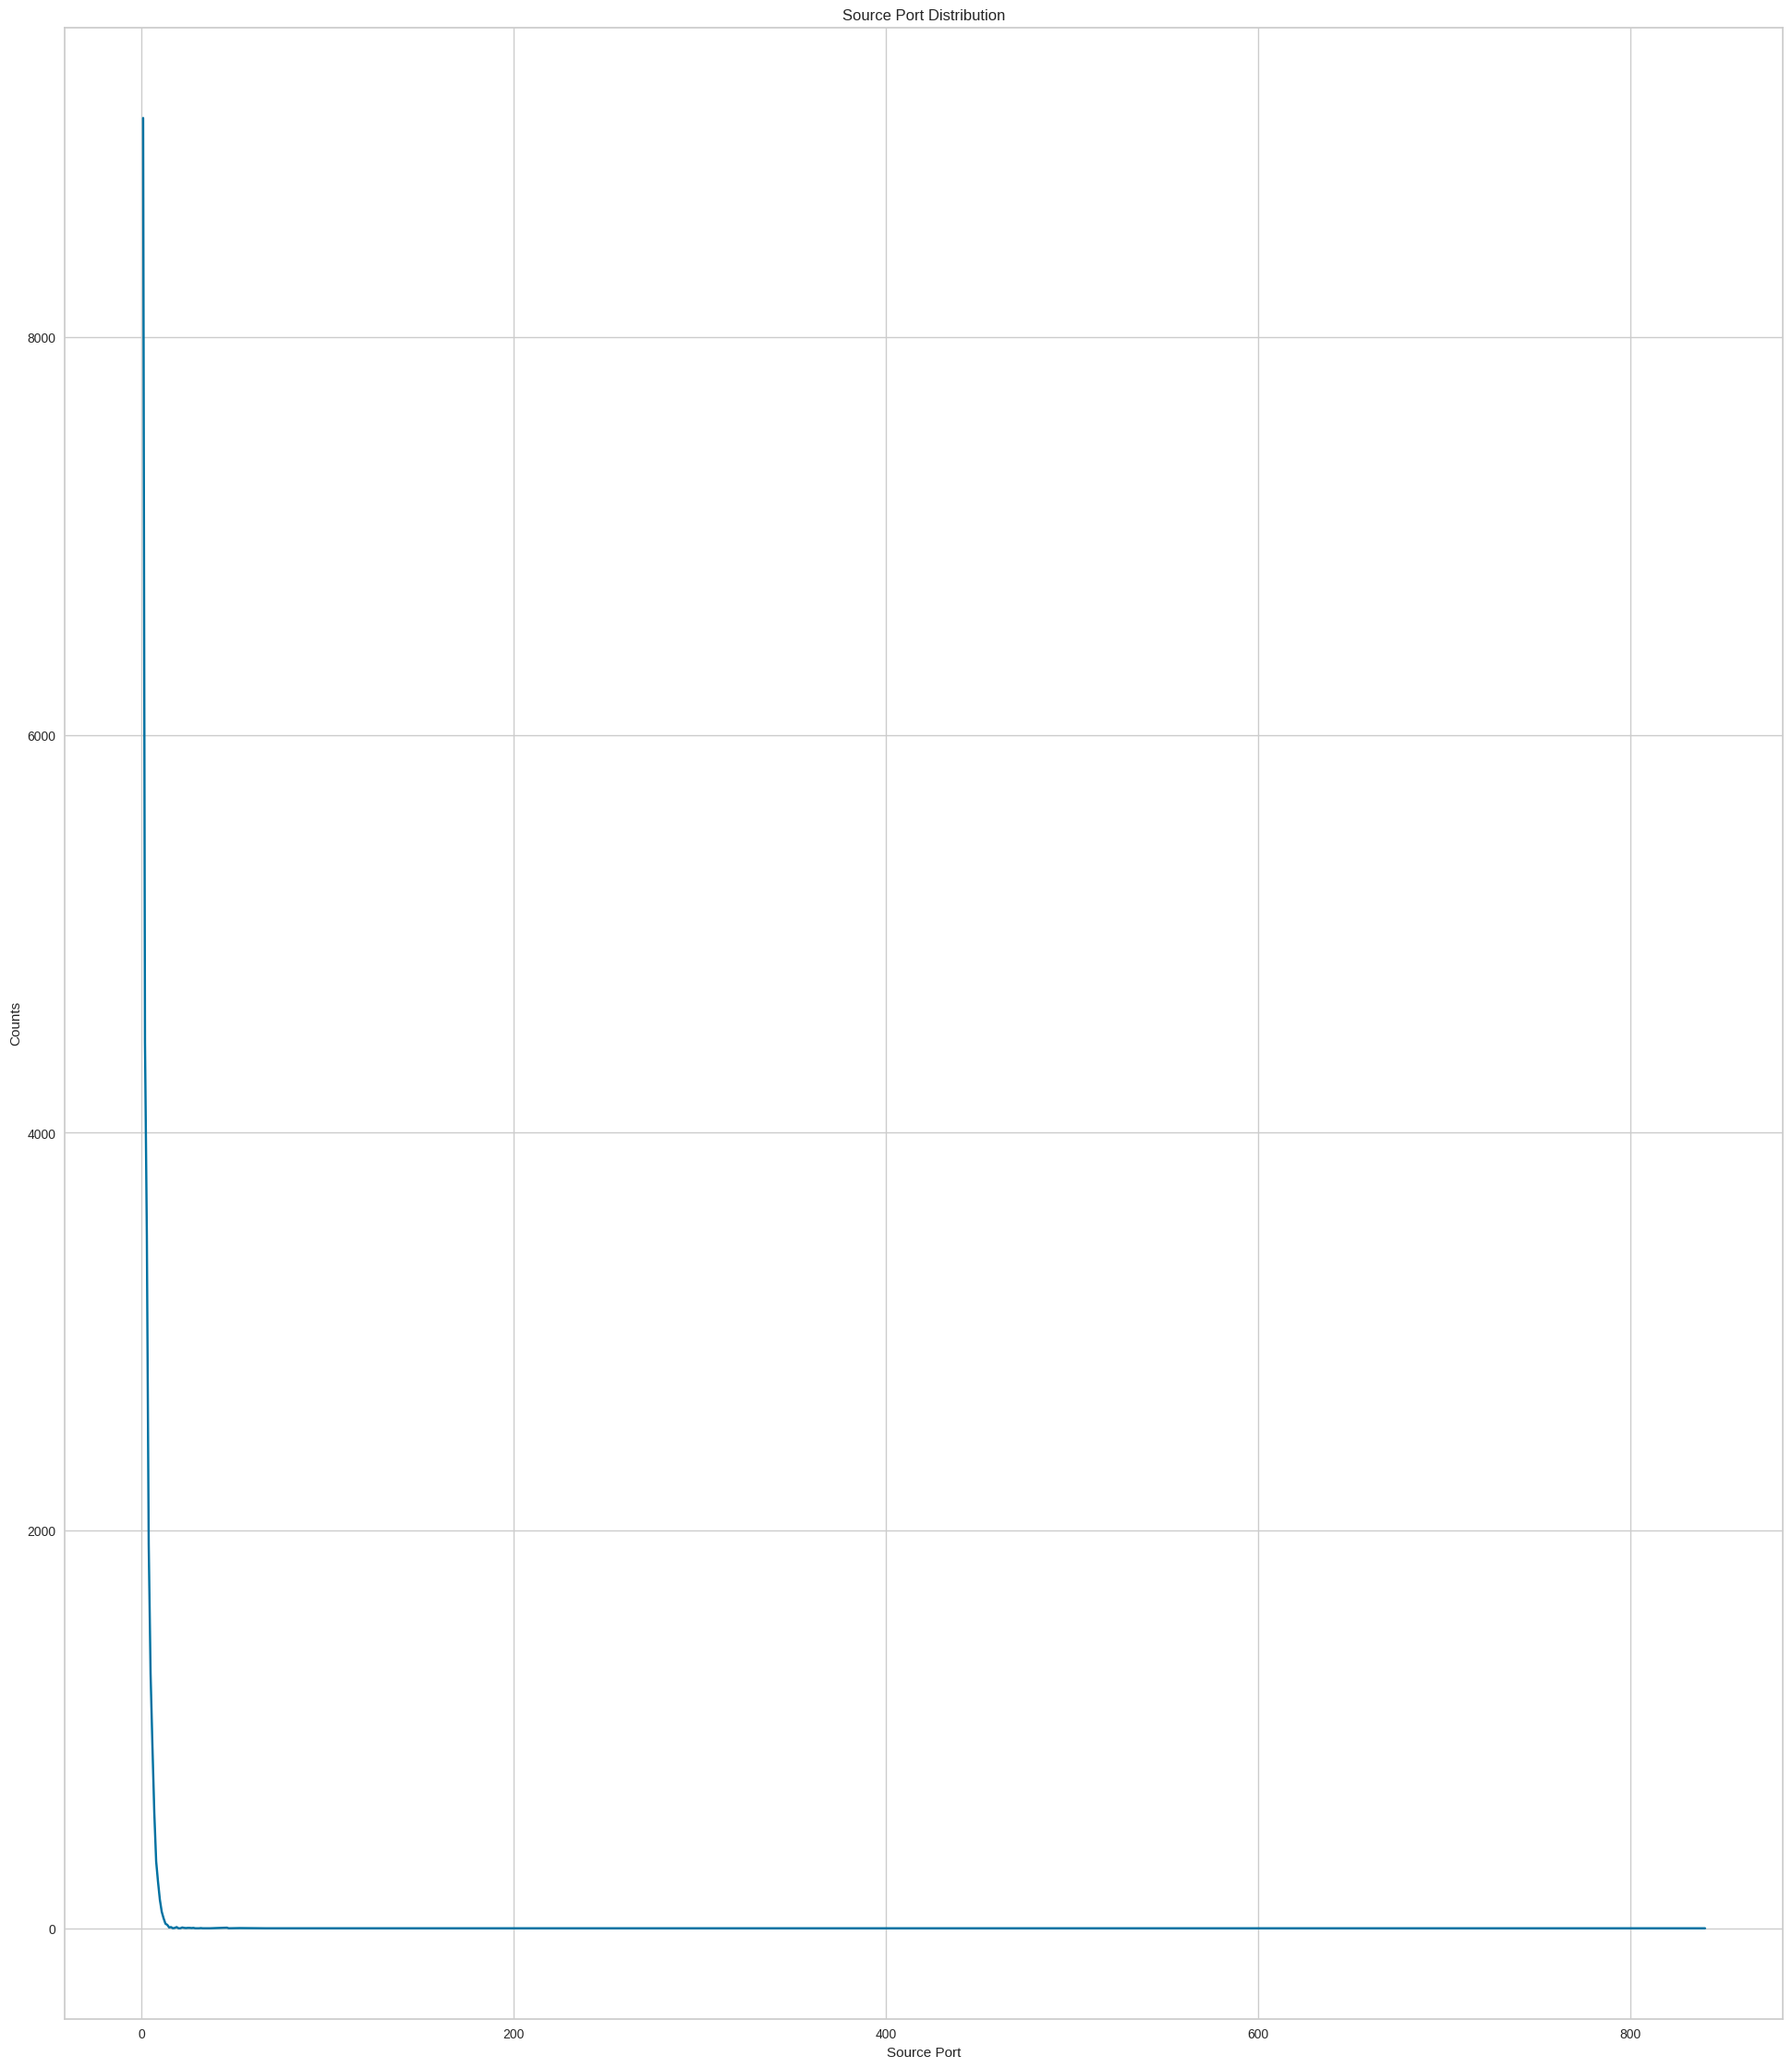

In [128]:
fig, ax = plt.subplots(figsize=(24,28))

# Generate sequential data and plot
x = sp_counts['counts']
y = sp_counts['Number_of_counts']
ax.plot(x, y)

# Add title and axis names
ax.set_title('Source Port Distribution')
ax.set_xlabel('Source Port')
ax.set_ylabel('Counts')

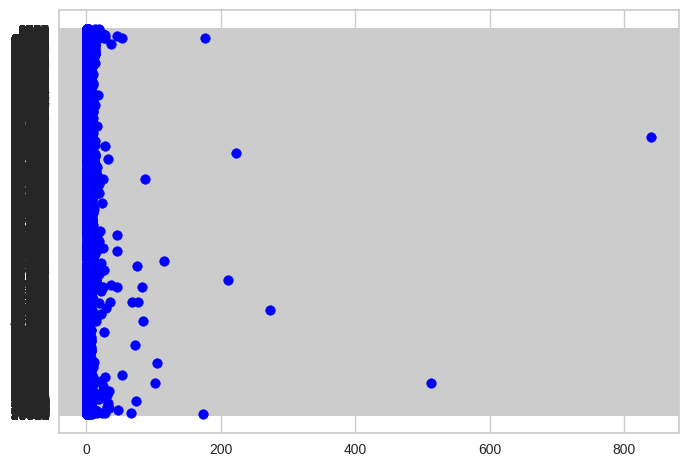

In [129]:
plt.scatter(sp_agg['counts'], y=sp_agg['Source Port'], c ="blue")

In [130]:
dp_agg = df.groupby(['Destination Port']).size().reset_index(name='counts')
dp_agg

,Destination Port,counts
0,0,173
1,1,85
2,10004,2
3,10010,9
4,10012,2
...,...,...
3268,993,40
3269,995,10
3270,9986,7
3271,9992,1


In [8]:
value_counts = df['Source Port'].value_counts()

#creating list of columns with fewer than 32 values to remove before turning into categorical column (equals .05% of the rows in this dataset)
droplist = pd.DataFrame(value_counts)
droplist = droplist[droplist['Source Port']< 32]
droplist = list(droplist.index.values)

value_counts_DP = df['Destination Port'].value_counts()

#creating list of columns with fewer than 32 values to remove before turning into categorical column (equals .05% of the rows in this dataset)
droplist_DP = pd.DataFrame(value_counts_DP)
droplist_DP = droplist_DP[droplist_DP['Destination Port']< 32]
droplist_DP = list(droplist_DP.index.values)
droplist_DP

['35894',
 '6889',
 '30317',
 '26296',
 '9571',
 '35253',
 '18375',
 '3478',
 '48637',
 '44512',
 '28189',
 '24748',
 '41615',
 '54532',
 '32468',
 '55783',
 '25',
 '60043',
 '5529',
 '35974',
 '26672',
 '1024',
 '33330',
 '57587',
 '67',
 '8100',
 '35776',
 '17500',
 '23388',
 '17',
 '50432',
 '55108',
 '55777',
 '65008',
 '21',
 '27019',
 '45682',
 '10387',
 '8696',
 '2225',
 '2710',
 '56125',
 '61689',
 '9694',
 '3111',
 '3855',
 '5555',
 '10214',
 '50321',
 '6882',
 '40108',
 '47993',
 '8168',
 '19473',
 '46776',
 '8000',
 '49152',
 '7275',
 '28793',
 '11119',
 '6969',
 '49756',
 '8055',
 '81',
 '19910',
 '49903',
 '51180',
 '37450',
 '52752',
 '20010',
 '7454',
 '46783',
 '28678',
 '41864',
 '8060',
 '60038',
 '66',
 '37',
 '50011',
 '11446',
 '1900',
 '17546',
 '27025',
 '6004',
 '30041',
 '51185',
 '62609',
 '3398',
 '38303',
 '10197',
 '38608',
 '33303',
 '34021',
 '64347',
 '58414',
 '2222',
 '3383',
 '48983',
 '8604',
 '1688',
 '54369',
 '33890',
 '3544',
 '45711',
 '53567',


In [10]:
len(droplist)

22691

In [11]:
len(droplist_DP)

3196

There are 22,724 distinct Source Ports in this dataset.

In [12]:
i=0

#Replacing low frequency Source Ports (under .05%), with "low-frequency" value, to limit the size of the dataframe

while i < len(droplist):
  df['Source Port']=df['Source Port'].replace((droplist[i]),"low-frequency")
  print(droplist[i])
  i+=1


Streaming output truncated to the last 5000 lines.
64623
47376
52834
16168
52823
52822
52821
6587
40108
52813
62924
58005
42672
34062
35811
43862
33462
48856
40403
35809
35117
42342
48209
1294
37627
9461
60497
47834
28679
37630
45397
64435
1130
38468
61864
35060
58394
45882
36351
56475
44299
40105
47928
37492
35917
4296
36402
44673
60008
63638
16776
39277
38707
58720
9483
48646
58931
9482
61123
36953
56064
44925
25808
58717
38102
56036
37299
8508
45295
47073
54634
38706
40042
43570
58070
39831
49046
46190
10063
47051
37320
44256
34316
39622
32945
55369
46830
48872
43546
35423
41243
46507
46715
47454
30644
37675
51033
52571
40249
34326
46963
52568
45482
41603
9270
40544
39434
52445
52443
41861
48798
38863
62722
60912
59821
60988
41898
28110
25202
9263
9261
9259
9245
41254
52982
64118
63947
48266
42107
37368
9253
33202
4650
65148
38279
37671
9257
56248
9468
64010
9262
64163
64165
64007
52389
52387
62242
52371
52369
52357
52349
9243
48984
9244
9260
9264
35939
9469
33933
40422
45822
62030


In [13]:
i=0

#Replacing low frequency Source Ports (under .05%), with "Dropped" value, to limit the size of the dataframe

while i < len(droplist_DP):
  df['Destination Port']=df['Destination Port'].replace((droplist_DP[i]),"low-frequency")
  print(droplist_DP[i])
  i+=1

35894
6889
30317
26296
9571
35253
18375
3478
48637
44512
28189
24748
41615
54532
32468
55783
25
60043
5529
35974
26672
1024
33330
57587
67
8100
35776
17500
23388
17
50432
55108
55777
65008
21
27019
45682
10387
8696
2225
2710
56125
61689
9694
3111
3855
5555
10214
50321
6882
40108
47993
8168
19473
46776
8000
49152
7275
28793
11119
6969
49756
8055
81
19910
49903
51180
37450
52752
20010
7454
46783
28678
41864
8060
60038
66
37
50011
11446
1900
17546
27025
6004
30041
51185
62609
3398
38303
10197
38608
33303
34021
64347
58414
2222
3383
48983
8604
1688
54369
33890
3544
45711
53567
995
50934
14446
50238
63710
53395
61686
33720
10010
49813
60496
47807
25773
55559
16386
16385
31652
39210
16933
28080
37649
65151
62732
65473
40005
9918
55839
53945
4607
14591
16384
25320
20541
35447
9822
62451
40031
56448
30228
7010
44091
55160
57354
30975
27020
4205
8497
45788
36653
3434
14037
1025
40002
24874
49001
7129
20087
27520
54507
31061
17637
46314
47783
56079
38211
52848
12446
44683
30627
3385
14914
16010


In [14]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'Action']

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list((set(cols) - set(num_cols)))

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
scaler = StandardScaler()
num_df = scaler.fit_transform(X[num_cols])

X=cat_df.join(pd.DataFrame(num_df,columns=X[num_cols].columns, index=X[num_cols].index))
X

,NAT Source Port_0,NAT Source Port_10000,NAT Source Port_10001,NAT Source Port_10002,NAT Source Port_10005,NAT Source Port_10007,NAT Source Port_10010,NAT Source Port_10011,NAT Source Port_10013,NAT Source Port_10014,...,Source Port_6881,Source Port_80,Source Port_low-frequency,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747
65528,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037
65529,1,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646
65530,1,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646


Updates for Source & Destination Port, changed column number from 57,689 down to 31,805 by replacing values which represented less than 99.95% of the data overall (to help make the model more efficient, since that is a requirement for this model to be leveraged).

In [15]:
X.describe()

,NAT Source Port_0,NAT Source Port_10000,NAT Source Port_10001,NAT Source Port_10002,NAT Source Port_10005,NAT Source Port_10007,NAT Source Port_10010,NAT Source Port_10011,NAT Source Port_10013,NAT Source Port_10014,...,Source Port_6881,Source Port_80,Source Port_low-frequency,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,65532.000000,...,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04
mean,0.433864,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,...,0.002701,0.000702,0.939083,2.168537e-18,-3.252805e-19,0.000000,-8.674147e-19,2.298649e-17,2.168537e-19,8.674147e-19
std,0.495611,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,...,0.051901,0.026485,0.239179,1.000008e+00,1.000008e+00,1.000008,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.727610e-02,-5.832069e-03,-0.030342,-1.984546e-02,-2.176608e-01,-1.255093e-02,-2.764633e-02
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,-1.727503e-02,-5.830501e-03,-0.030342,-1.984546e-02,-2.176608e-01,-1.255093e-02,-2.764633e-02
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,-1.725687e-02,-5.824232e-03,-0.030310,-1.965064e-02,-1.680674e-01,-1.255093e-02,-2.719655e-02
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,-1.715288e-02,-5.792885e-03,-0.030160,-1.887137e-02,-1.184740e-01,-1.192959e-02,-2.674677e-02
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.259118e+02,2.477606e+02,130.240541,2.018353e+02,3.556895e+01,2.322194e+02,1.471436e+02


In [16]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['Action']]
#y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

In [17]:
y_alt

,Action
0,allow
1,allow
2,allow
3,allow
4,allow
...,...
65527,allow
65528,allow
65529,drop
65530,drop


In [18]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=100000,tol=0.01)
X_train,X_test, y_train,y_test = train_test_split(X,y_alt)

In [ ]:
for C in np.logspace(-6,6,20):
    model.C = C
    model.fit(X_train,y_train)
    p=model.predict(X_test)
    print(accuracy_score(y_test,p), C)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5999511688945859 1e-06


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9949337728132821 4.281332398719396e-06


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.990661051089544 1.8329807108324375e-05


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.990661051089544 7.847599703514606e-05


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.990661051089544 0.0003359818286283781


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.990661051089544 0.0014384498882876629


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9960935115668681 0.00615848211066026


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9963987059757066 0.026366508987303555


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9967039003845449 0.11288378916846883


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9966428615027773 0.4832930238571752


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9970701336751511 2.06913808111479


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9971311725569187 8.858667904100814


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9971311725569187 37.92690190732246


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9971311725569187 162.37767391887175


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9982298724287371 695.1927961775591


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
model.C = 0.005
model.fit(X_train,y_train)
p=model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,p))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       allow       1.00      0.99      1.00      9429
        deny       0.98      0.99      0.99      3654
        drop       1.00      1.00      1.00      3284
  reset-both       0.00      0.00      0.00        16

    accuracy                           0.99     16383
   macro avg       0.74      0.75      0.75     16383
weighted avg       0.99      0.99      0.99     16383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
X.columns

Index(['NAT Source Port_0', 'NAT Source Port_10000', 'NAT Source Port_10001',
       'NAT Source Port_10002', 'NAT Source Port_10005',
       'NAT Source Port_10007', 'NAT Source Port_10010',
       'NAT Source Port_10011', 'NAT Source Port_10013',
       'NAT Source Port_10014',
       ...
       'Source Port_6881', 'Source Port_80', 'Source Port_low-frequency',
       'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object', length=31804)

In [77]:
scores = np.dot(X, model.coef_.T)

In [72]:
X.columns

Index(['NAT Source Port_0', 'NAT Source Port_10000', 'NAT Source Port_10001',
       'NAT Source Port_10002', 'NAT Source Port_10005',
       'NAT Source Port_10007', 'NAT Source Port_10010',
       'NAT Source Port_10011', 'NAT Source Port_10013',
       'NAT Source Port_10014',
       ...
       'Source Port_6881', 'Source Port_80', 'Source Port_low-frequency',
       'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object', length=31804)

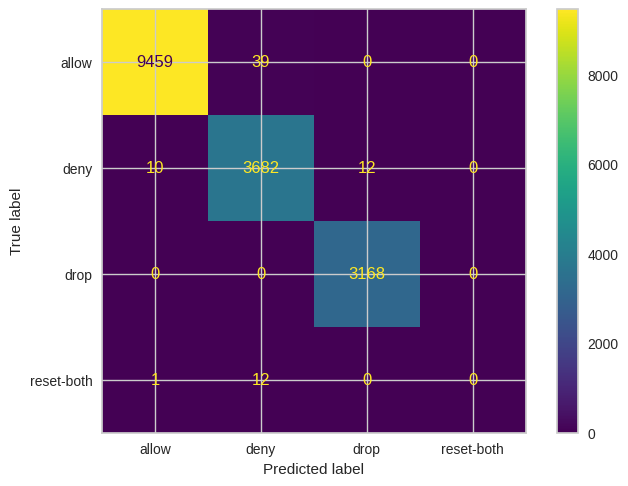

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,p)

In [ ]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=0.005).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
p=rbf.predict(X_test)
print(classification_report(y_test,p))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,p)